In [1]:
## Imports
import sys
import os
import time
import math
import random
import h5py
import re

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
import plot_utils
import notebook_utils_2

from sklearn.metrics import roc_curve, auc

In [2]:
# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"neutron", 1:"e"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

# Fix the colour scheme for each particle type
COLOR_DICT = {"neutron":"red", "e":"blue"}


In [3]:
# Plot distribution of predictions
def plot_softmax_scatter(softmaxes, labels, energies, softmax_index_dict,
                 min_energy=0, max_energy=1500, save_path=None):
    
    # Remove energy outside of range
    energy_slice_map = [False for i in range(len(energies))]
    
    for i in range(len(energies)):
        if(energies[i] >= min_energy and energies[i] < max_energy):
                energy_slice_map[i] = True
                
    curr_softmax = softmaxes[energy_slice_map] 
    curr_labels = labels[energy_slice_map]
    
    fig, axs = plt.subplots(1,3, figsize=(16,5))
    
    # Histogram of counts by prediction
    for i, ax in enumerate([axs[0], axs[1]]):
        ax.hist(softmaxes[labels==i], label=[LABEL_DICT[i] for i in range(2)])
        ax.set_ylabel("Count")
        ax.set_xlabel("Prediction")
        ax.set_title("Historgram of Predictions {}".format(LABEL_DICT[i]))
        ax.legend()
    
    # Scatterplot
    ax = axs[2]
    ax.scatter(softmaxes[:,0], softmaxes[:,1])
    ax.set_xlabel(LABEL_DICT[0])
    ax.set_ylabel(LABEL_DICT[1])
    ax.set_title("Prediction Value of {} vs {}".format(LABEL_DICT[0], LABEL_DICT[1]))
    
    fig.tight_layout()
    
    if save_path is not None:
        fig.savefig(save_path)
    
    

In [4]:
# Plot the ROC curve for one vs another class
def plot_new_ROC(softmaxes, labels, energies, softmax_index_dict, label_0, label_1, 
                 min_energy=0, max_energy=1500, show_plot=False, save_path=None):
    
    """Plot the signal efficiency vs. background rejection from softmax output
    
    softmaxes          -- 2D np array with shape (num_examples, num_classes)
    labels             -- 1D np array with true ordinal labels e.g. [0,1,2,0,1,...]
    energies           -- 1D np array with true energies for each event
    softmax_index_dict -- Dictionary mapping str class ids e.g. "neutron" to axis=1 idx
                          in the softmax array
    label_0            -- str class id for the signal class e.g. "neutron"
    label_1            -- str class id for the background class e.g. "e"
    min_energy         -- Minimum energy of the events to consider when plot the signal
                          efficiency vs background rejection plots
    max_energy         -- Maximum energy of the events to consider when plot the signal
                          efficiency vs background rejection plots
    show               -- Boolean to determine whether to call plt.show()
    save_path          -- Absolute path of the location at which to save the plot        
    """
    
    assert softmaxes is not None
    assert labels is not None
    assert softmax_index_dict  is not None
    assert softmaxes.shape[0] == labels.shape[0]
    assert label_0 in softmax_index_dict.keys()
    assert label_1 in softmax_index_dict.keys()
    
    #------------------------------------------------------------------------
    # Create a boolean map to select events in the user-defined energy range
    #------------------------------------------------------------------------
    
    energy_slice_map = [False for i in range(len(energies))]
    
    for i in range(len(energies)):
        if(energies[i] >= min_energy and energies[i] < max_energy):
                energy_slice_map[i] = True
                
    curr_softmax = softmaxes[energy_slice_map] 
    curr_labels = labels[energy_slice_map]
    
    #------------------------------------------------------------------------
    # Extract the softmax and true label values for signal and background events
    #------------------------------------------------------------------------
    
    # Extract the useful softmax and labels from the input arrays
    softmax_0 = curr_softmax[curr_labels==softmax_index_dict[label_0]]
    labels_0 = curr_labels[curr_labels==softmax_index_dict[label_0]] 
    
    softmax_1 = curr_softmax[curr_labels==softmax_index_dict[label_1]]
    labels_1 = curr_labels[curr_labels==softmax_index_dict[label_1]]
    
    # Add the two arrays
    softmax = np.concatenate((softmax_0, softmax_1), axis=0)
    labels = np.concatenate((labels_0, labels_1), axis=0)
    print("got this far 0!")

    #------------------------------------------------------------------------
    # Compute the ROC curve and the AUC for class corresponding to label 0
    #------------------------------------------------------------------------
    
    #print(labels)
    #print(softmax)
    fpr, tpr, threshold = roc_curve(labels, softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])
    print('fpr', fpr)
    print('tpr', tpr)
    print('threshold', threshold)
    roc_auc = auc(fpr, tpr)
    print('fpr', fpr)
    print('tpr', tpr)
    print('threshold', threshold)
    print('roc_auc', roc_auc)
    
    inv_fpr = []
    for i in fpr:
        inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)
        
    tnr = 1. - fpr
    print('inv_fpr',inv_fpr)
    print('tnr',tnr)
    
    if show_plot or save_path is not None:
        
        # TNR vs TPR plot
        fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
        ax.tick_params(axis="both", labelsize=20)

        ax.plot(tpr, inv_fpr, color=COLOR_DICT[label_1],
                 label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=COLOR_DICT[label_1])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, inv_fpr, tnr):
            xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
            xy_plot = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)

        ax.set_title(r"${0} \leq E < {1}$".format(round(min_energy,2), round(max_energy,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        #plt.yscale("log")
    print("got this far 1!")
        
    if save_path is not None:
        plt.savefig(save_path)
    print("got this far 2!")
    
    if show_plot:
        plt.show()
    print("got this far 3!")
        
    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
    print("got this far 4!")
        
        
    return fpr, tpr, threshold, roc_auc

In [5]:
# Input Data
dump_path = "/home/jwalker/data/NeutronGNN/dump/"
data_folder = "/home/jwalker/data/NeutronGNN/"
h5_file = os.path.join(data_folder, "iwcd_mpmt_shorttank_neutrongnn_trainval.h5")
indices_file = os.path.join(data_folder, "iwcd_mpmt_shorttank_neutrongnn_trainval_idxs.npz")

In [6]:
with h5py.File(h5_file, 'r') as h5_data:
#     print(list(h5_data.keys()))    
    indices_data = np.load(indices_file)

    h5_labels = h5_data['labels'][()][indices_data['val_idxs']]
    h5_energies = h5_data['energies'][()][indices_data['val_idxs']]

In [7]:
val_ids = ["gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_152800_0.6891586184501648",
           "gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_170800_0.6886608600616455", 
           "gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_47600_0.6892354488372803",
           "gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_86600_0.6893070936203003",
           "gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_89800_0.6891321539878845"]

gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_152800_0.6891586184501648
got this far 0!
fpr [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
tpr [0.00000000e+00 1.33438305e-05 3.20251932e-03 3.22920698e-03
 9.39405666e-03 9.42074432e-03 1.93218665e-02 1.93485542e-02
 2.20173203e-02 2.20440080e-02 2.89827998e-02 2.90094875e-02
 2.96099598e-02 2.96366475e-02 3.23187574e-02 3.23454451e-02
 3.25055710e-02 3.25322587e-02 3.25589464e-02 3.25856340e-02
 3.97245833e-02 3.97512710e-02 5.06398367e-02 5.06665243e-02
 5.24946291e-02 5.25213168e-02 5.44027969e-02 5.44294845e-02
 5.51500514e-02 5.51767390e-02 5.61908702e-02 5.62175578e-02
 5.68714055e-02 5.68980932e-02 5.75119094e-02 5.75385970e-02
 5.82191324e-02 5.82458200e-02 6.02607384e-02 6.02874261e-02


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:780: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:88: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


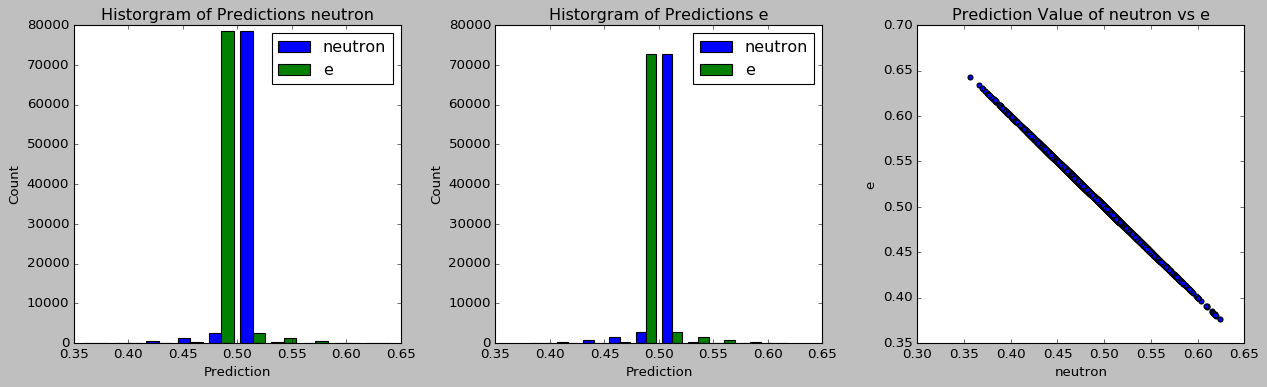

ValueError: 
\neutron
^
Unknown symbol: \neutron, found '\'  (at char 0), (line:1, col:1)

<Figure size 1280x720 with 1 Axes>

got this far 3!
got this far 4!
gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_170800_0.6886608600616455
got this far 0!
fpr [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
tpr [0.00000000e+00 1.33438305e-05 1.02747495e-03 1.05416261e-03
 5.24412538e-03 5.27081304e-03 1.88681763e-02 1.88948640e-02
 1.94019295e-02 1.94286172e-02 2.23642599e-02 2.23909475e-02
 2.55534354e-02 2.55801230e-02 2.88493615e-02 2.88760492e-02
 3.02237760e-02 3.02504637e-02 3.14647523e-02 3.14914399e-02
 3.15314714e-02 3.15581591e-02 3.33862639e-02 3.34129515e-02
 3.57080904e-02 3.57347780e-02 3.74694760e-02 3.74961636e-02
 3.84569194e-02 3.84836071e-02 3.93242684e-02 3.93509561e-02


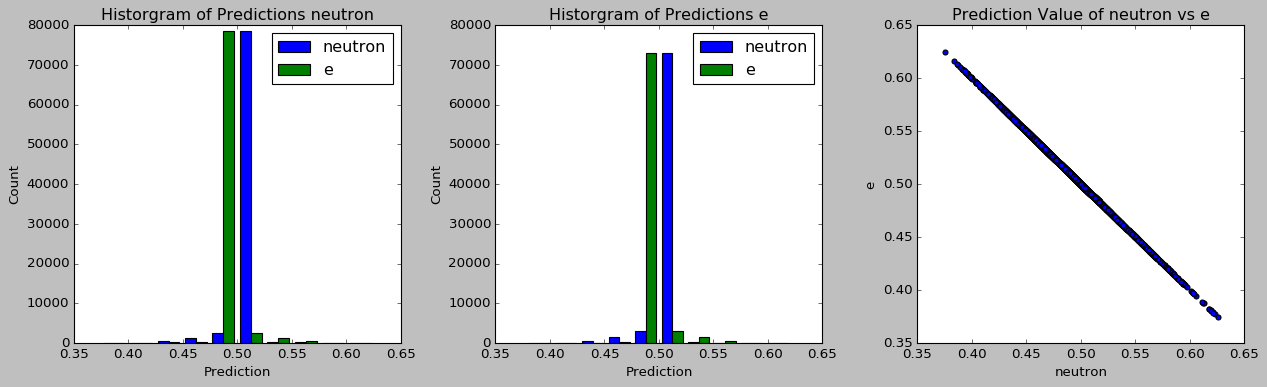

ValueError: 
\neutron
^
Unknown symbol: \neutron, found '\'  (at char 0), (line:1, col:1)

<Figure size 1280x720 with 1 Axes>

got this far 3!
got this far 4!
gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_47600_0.6892354488372803
got this far 0!
fpr [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan]
tpr [0.00000000e+00 1.33438305e-05 1.25165130e-02 1.25432007e-02
 1.26632951e-02 1.26899828e-02 1.46648697e-02 1.46915574e-02
 1.54654995e-02 1.54921872e-02 1.92151159e-02 1.92418036e-02
 2.10031892e-02 2.10298768e-02 2.47661494e-02 2.47928370e-02
 3.28791983e-02 3.29058860e-02 3.59616231e-02 3.59883108e-02
 3.81766990e-02 3.82033867e-02 4.13925621e-02 4.14192498e-02
 4.22732550e-02 4.22999426e-02 5.85527281e-02 5.85794158e-02
 6.02473946e-02 6.02740823e-02 6.20621556e-02 6.20888432e-02
 6.44240136e-02 6.44507012e-02 6.62120868e-02 6.62387745e-02
 6.64255881e-02 6.64522758e-02 6.74130316e-02 6.74397192e-02
 6.89208844e-

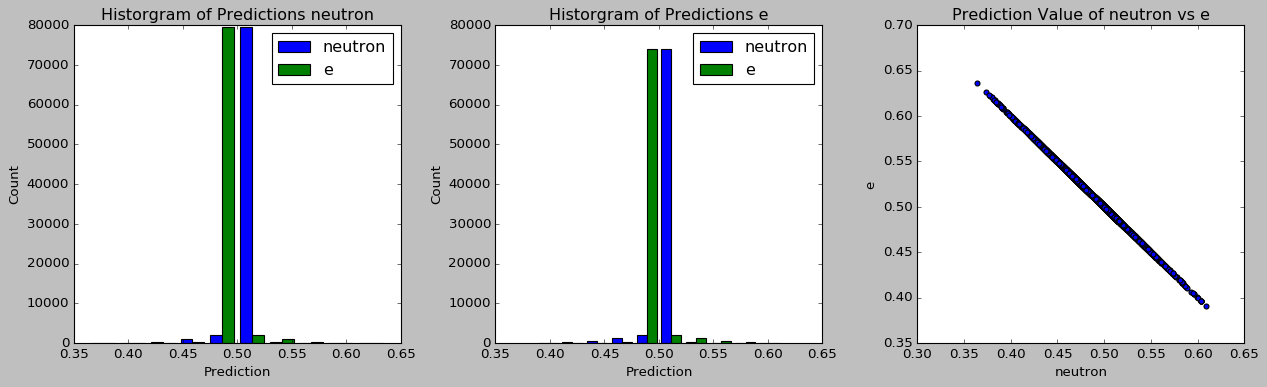

ValueError: 
\neutron
^
Unknown symbol: \neutron, found '\'  (at char 0), (line:1, col:1)

<Figure size 1280x720 with 1 Axes>

got this far 3!
got this far 4!
gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_86600_0.6893070936203003
got this far 0!
fpr [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
tpr [0.00000000e+00 1.33438305e-05 1.05416261e-02 1.05683137e-02
 1.12355053e-02 1.12621929e-02 1.14089751e-02 1.14356627e-02
 2.37787059e-02 2.38053936e-02 2.40188949e-02 2.40455825e-02
 4.00581791e-02 4.00848668e-02 4.06186200e-02 4.06453076e-02
 4.52756168e-02 4.53023045e-02 4.71971284e-02 4.72238161e-02
 4.80111021e-02 4.80377897e-02 6.10747121e-02 6.11013998e-02
 6.28494416e-02 6.28761292e-02 6.31163182e-02 6.31430058e-02
 6.53047064e-02 6.53313940e-02 7.20166531e-02 7.20433408e-02
 7.37246634e-02 7.37513511e-02 7.64868363e-02 7.65135240e-02
 7.94758543e-02 7.95025420e-02 8.74821526e-02 9.09915800e-02
 9.90992914e-01 9.91566699e-01 9.91593387e-01 9.92

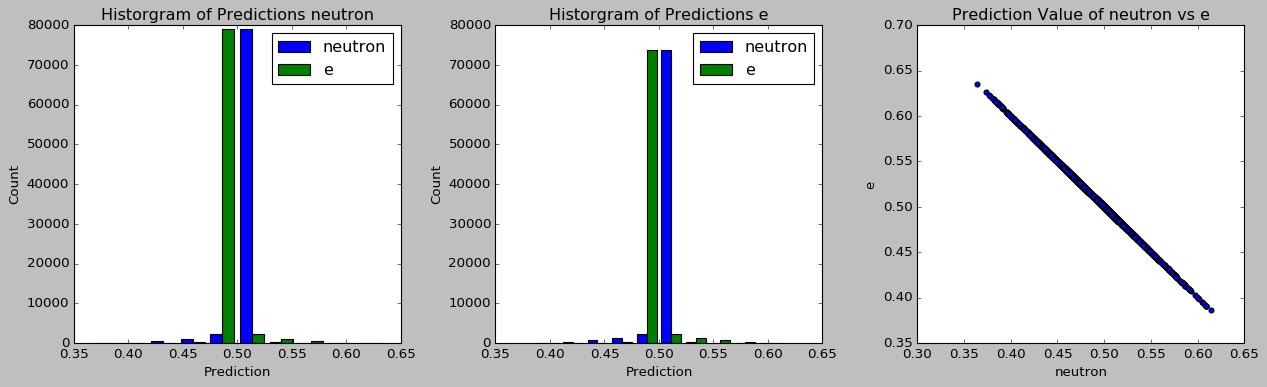

ValueError: 
\neutron
^
Unknown symbol: \neutron, found '\'  (at char 0), (line:1, col:1)

<Figure size 1280x720 with 1 Axes>

got this far 3!
got this far 4!
gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_89800_0.6891321539878845
got this far 0!
fpr [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
tpr [0.00000000e+00 1.33438305e-05 7.55260805e-03 7.57929571e-03
 1.21028542e-02 1.21295419e-02 2.26444803e-02 2.26711680e-02
 2.45926796e-02 2.46193672e-02 3.53211193e-02 3.53478069e-02
 4.00181476e-02 4.00448353e-02 4.60362152e-02 4.60629028e-02
 4.72638476e-02 4.72905352e-02 5.43627654e-02 5.43894530e-02
 5.46830173e-02 5.47097050e-02 5.86594788e-02 5.86861665e-02
 6.43306067e-02 6.43572944e-02 6.68259030e-02 6.68525907e-02
 7.90888833e-02 7.91155709e-02 8.53204521e-02 8.53471397e-02
 8.81093127e-02 9.90726038e-01 9.90939539e-01 9.90966227e-01
 9.91540011e-01 9.91566699e-01 9.91873607e-01 9.91900295e-01
 9.92474080e-01 9.92500767e-01 1.00000000e+00]
threshold [1.60677683 0.6067768

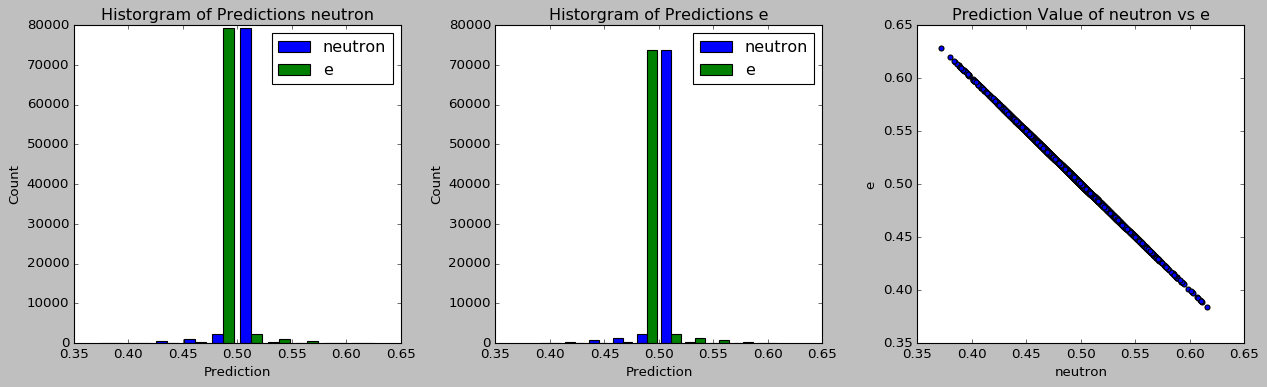

ValueError: 
\neutron
^
Unknown symbol: \neutron, found '\'  (at char 0), (line:1, col:1)

<Figure size 1280x720 with 1 Axes>

got this far 3!
got this far 4!


In [8]:
for val_id in val_ids:
    print(val_id)
    
    # Input Data
    dump_folder = os.path.join(dump_path, val_id)
    
    # Output Data
    save_fig_loc_0 = None
    #save_fig_loc_0 = os.path.join(dump_folder, "roc_auc.png")
    save_fig_loc_1 = os.path.join(dump_folder, "histogram.png")
    output_loc = os.path.join(dump_folder, "roc_auc_output.npz")

    # Get predictions
    softmaxes = np.array([]).reshape(0,2)
    regex = re.compile('\d+\.npz')
    ## label_index = 0
    tmp_files = os.listdir(dump_folder)
    np_files = [f for f in tmp_files if regex.match(f) is not None]

    for np_file in sorted(np_files, key=lambda x: int(os.path.splitext(x)[0])):
        tmp = np.load(os.path.join(dump_folder, np_file))

    ##     l_shape = tmp['label'].shape
    ##     print(np.all(h5_labels[label_index:label_index+l_shape[0]] == tmp['label']))
    ##     label_index += l_shape[0]

        softmaxes = np.concatenate([softmaxes, tmp['pred_val']])
    
    # Plotting
    plot_softmax_scatter(softmaxes, h5_labels, h5_energies, softmax_index_dict, 
                 min_energy=0, max_energy=20, save_path=save_fig_loc_1)
    out = plot_new_ROC(softmaxes, h5_labels, h5_energies, softmax_index_dict, "e", "neutron", 
                 min_energy=0, max_energy=20, show_plot=True, save_path=save_fig_loc_0)
    #np.savez(output_loc, fpr=out[0], tpr=out[1], threshold=out[2], roc_auc=out[3])

In [9]:
for val_id in val_ids:
    print(val_id)
    
    # Input Data
    dump_folder = os.path.join(dump_path, val_id)
    
    softmaxes = np.array([]).reshape(0,2)
    regex = re.compile('\d+\.npz')
    # label_index = 0
    tmp_files = os.listdir(dump_folder)
    np_files = [f for f in tmp_files if regex.match(f) is not None]

    for np_file in sorted(np_files, key=lambda x: int(os.path.splitext(x)[0])):
        tmp = np.load(os.path.join(dump_folder, np_file))

    #     l_shape = tmp['label'].shape
    #     print(np.all(h5_labels[label_index:label_index+l_shape[0]] == tmp['label']))
    #     label_index += l_shape[0]

        softmaxes = np.concatenate([softmaxes, tmp['pred_val']])
    
    out = plot_new_ROC(softmaxes, h5_labels, h5_energies, softmax_index_dict, "neutron", "e", 
                 min_energy=0, max_energy=20, show_plot=True)

gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_152800_0.6891586184501648
got this far 0!
fpr [0.00000000e+00 1.33438305e-05 8.21979958e-03 8.24648724e-03
 8.32655022e-03 8.35323788e-03 8.37992554e-03 8.40661320e-03
 8.64680215e-03 8.67348981e-03 9.07380473e-03 6.62094181e-01
 9.00214836e-01 9.04644987e-01 9.04671675e-01 9.09235265e-01
 9.09261953e-01 9.10329459e-01 9.10356147e-01 9.11677186e-01
 9.11703874e-01 9.11984094e-01 9.12010782e-01 9.16174057e-01
 9.16200745e-01 9.19429952e-01 9.19456639e-01 9.27796533e-01
 9.27823221e-01 9.30972365e-01 9.30999053e-01 9.32560281e-01
 9.32586968e-01 9.33481005e-01 9.33507693e-01 9.35002202e-01
 9.35028889e-01 9.35135640e-01 9.35162328e-01 9.35175672e-01
 9.35202359e-01 9.39592479e-01 9.39619167e-01 9.39632511e-01
 9.39659199e-01 9.41447272e-01 9.41473960e-01 9.43101907e-01
 9.43128594e-01 9.43181970e-01 9.43208657e-01 9.43782442e-01
 9.43809130e-01 9.54324068e-01 9.54350756e-01 9.59368036e-01
 9.59394724e-01 9.60248729e-01 9.60275417e-01

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:788: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


ValueError: 
\neutron
^
Unknown symbol: \neutron, found '\'  (at char 0), (line:1, col:1)

<Figure size 1280x720 with 1 Axes>

got this far 3!
got this far 4!
gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_170800_0.6886608600616455
got this far 0!
fpr [0.00000000e+00 1.33438305e-05 6.09813053e-03 6.12481819e-03
 8.28651873e-03 8.31320639e-03 8.36658171e-03 8.39326937e-03
 8.44664469e-03 8.47333235e-03 8.60677066e-03 8.63345832e-03
 8.75355279e-03 8.79358429e-03 8.99374174e-03 9.02042940e-03
 9.43408815e-03 8.97959728e-01 8.98360043e-01 8.98386731e-01
 8.98520169e-01 8.98546857e-01 8.99614363e-01 8.99641051e-01
 8.99881240e-01 8.99907928e-01 8.99987991e-01 9.00014678e-01
 9.00535088e-01 9.00561775e-01 9.00948746e-01 9.00975434e-01
 9.01789408e-01 9.01816095e-01 9.01829439e-01 9.01856127e-01
 9.08474667e-01 9.08501354e-01 9.08794919e-01 9.08821606e-01
 9.13905606e-01 9.13932293e-01 9.14426015e-01 9.14452703e-01
 9.14479390e-01 9.14506078e-01 9.15840461e-01 9.15867149e-01
 9.26702339e-01 9.26729027e-01 9.27316155e-01 9.27342843e-01
 9.28877384e-01 9.28904071e-01 9.29838139e-01 9.29864827e-01
 9.32293404e-

ValueError: 
\neutron
^
Unknown symbol: \neutron, found '\'  (at char 0), (line:1, col:1)

<Figure size 1280x720 with 1 Axes>

got this far 3!
got this far 4!
gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_47600_0.6892354488372803
got this far 0!
fpr [0.00000000e+00 1.33438305e-05 3.01570569e-03 3.04239335e-03
 8.01964212e-03 8.04632978e-03 8.62011449e-03 8.64680215e-03
 8.91367876e-03 8.94036642e-03 9.46077581e-03 9.20510802e-01
 9.21618340e-01 9.21645027e-01 9.22685846e-01 9.22712534e-01
 9.24020229e-01 9.24046917e-01 9.26662308e-01 9.26688995e-01
 9.26969216e-01 9.26995903e-01 9.30158391e-01 9.30185079e-01
 9.33547724e-01 9.33574412e-01 9.33761225e-01 9.33787913e-01
 9.35549299e-01 9.35575986e-01 9.35989645e-01 9.36016333e-01
 9.37911157e-01 9.37937844e-01 9.38258096e-01 9.38284784e-01
 9.39725918e-01 9.39752605e-01 9.43835818e-01 9.43862505e-01
 9.44543041e-01 9.44569728e-01 9.57646682e-01 9.57673370e-01
 9.58580750e-01 9.58607438e-01 9.60835858e-01 9.60862545e-01
 9.61342923e-01 9.61369611e-01 9.65639637e-01 9.65666324e-01
 9.76981892e-01 9.77008580e-01 9.78970123e-01 9.78996811e-01
 9.80718165e-0

ValueError: 
\neutron
^
Unknown symbol: \neutron, found '\'  (at char 0), (line:1, col:1)

<Figure size 1280x720 with 1 Axes>

got this far 3!
got this far 4!
gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_86600_0.6893070936203003
got this far 0!
fpr [0.00000000e+00 1.33438305e-05 5.79122243e-03 5.81791009e-03
 7.72607785e-03 7.75276551e-03 7.87285998e-03 7.89954764e-03
 7.92623531e-03 7.95292297e-03 8.64680215e-03 8.67348981e-03
 9.00708557e-03 9.12517847e-01 9.12544535e-01 9.16534340e-01
 9.16561028e-01 9.20070455e-01 9.20097143e-01 9.26302024e-01
 9.26328712e-01 9.27956659e-01 9.27983347e-01 9.30558706e-01
 9.30585394e-01 9.36856994e-01 9.36883682e-01 9.37670968e-01
 9.37697655e-01 9.38898600e-01 9.38925288e-01 9.41300490e-01
 9.41327177e-01 9.41447272e-01 9.41473960e-01 9.42568154e-01
 9.42594841e-01 9.46678053e-01 9.46704741e-01 9.52776184e-01
 9.52802872e-01 9.60048572e-01 9.60075259e-01 9.69215783e-01
 9.69242471e-01 9.70710292e-01 9.70736980e-01 9.75300570e-01
 9.75327257e-01 9.76194606e-01 9.76221294e-01 9.77355520e-01
 9.77382207e-01 9.77742491e-01 9.77769178e-01 9.80571383e-01
 9.80598070e-0

ValueError: 
\neutron
^
Unknown symbol: \neutron, found '\'  (at char 0), (line:1, col:1)

<Figure size 1280x720 with 1 Axes>

got this far 3!
got this far 4!
gcn_kipf20200203_151411/valid_validation_gcn_kipf_best_89800_0.6891321539878845
got this far 0!
fpr [0.00000000e+00 1.33438305e-05 7.49923273e-03 7.52592039e-03
 8.04632978e-03 8.07301744e-03 8.23314341e-03 8.25983107e-03
 8.33989405e-03 8.36658171e-03 8.43330086e-03 8.45998852e-03
 9.27396218e-03 9.11890687e-01 9.12144220e-01 9.12170908e-01
 9.17348314e-01 9.17375002e-01 9.19723516e-01 9.19750203e-01
 9.30371893e-01 9.30398580e-01 9.51348394e-01 9.51375082e-01
 9.52709465e-01 9.52736152e-01 9.53937097e-01 9.53963785e-01
 9.60275417e-01 9.60302104e-01 9.60382167e-01 9.60408855e-01
 9.61009327e-01 9.61036015e-01 9.66613736e-01 9.66640424e-01
 9.73232276e-01 9.73258964e-01 9.75380633e-01 9.75407320e-01
 9.77328832e-01 9.77355520e-01 9.77755835e-01 9.77782522e-01
 9.83573745e-01 9.83600432e-01 9.89765282e-01 9.89791970e-01
 9.92420704e-01 9.92447392e-01 1.00000000e+00]
tpr [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan

ValueError: 
\neutron
^
Unknown symbol: \neutron, found '\'  (at char 0), (line:1, col:1)

<Figure size 1280x720 with 1 Axes>

got this far 3!
got this far 4!
